In [23]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [4]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [5]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    concat_df = concat_df.reset_index(drop=True)
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    return concat_df

In [6]:
yunrip_df = data_prep('연립다세대', '매매')
print(yunrip_df.shape)
yunrip_df.head()

16it [00:01,  8.61it/s]


(689651, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 1264-3,개포로31길 23-7,(1264-3),53.28,29.23,11500,-1,1992.0,14.0,2006-08-29,215.840841,29.0
1,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0
3,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0
4,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0


In [7]:
officetel_df = data_prep('오피스텔', '매매')
print(officetel_df.shape)
officetel_df.head()

16it [00:00, 32.45it/s]


(178693, 11)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
#land_specs_df['지형형상2'] = land_specs_df['지형형상'].apply(land_shape2)
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
yunrip_merge_df = yunrip_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
officetel_merge_df = officetel_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [11]:
yunrip_df['구'] = yunrip_df['지번주소'].apply(lambda x: x.split(' ')[1])
yunrip_df['동'] = yunrip_df['지번주소'].apply(lambda x: x.split(' ')[2])
yunrip_merge_df['구'] = yunrip_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
yunrip_merge_df['동'] = yunrip_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])
officetel_df['구'] = officetel_df['지번주소'].apply(lambda x: x.split(' ')[1])
officetel_df['동'] = officetel_df['지번주소'].apply(lambda x: x.split(' ')[2])
officetel_merge_df['구'] = officetel_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
officetel_merge_df['동'] = officetel_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '강동구'
target_dong = '성내동'
target_purpose = '3종일반'

In [13]:
target_df = yunrip_merge_df[
    (yunrip_merge_df['구'] == target_gu)
    &(yunrip_merge_df['동'] == target_dong)
    &(yunrip_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=18)))
    &(yunrip_merge_df['건물연식'] <= 4)
    #&(yunrip_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(488, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
11394,서울특별시 강동구 성내동 458-1,성내로6나길 8,한강파크빌,31.50,24.75,37700,6,2018.0,2.0,2020-07-31,1196.825397,3.0,대,393.3,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),강동구,성내동
11395,서울특별시 강동구 성내동 458-1,성내로6나길 8,한강파크빌,36.90,25.62,38700,4,2018.0,3.0,2021-01-09,1048.780488,3.0,대,393.3,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),강동구,성내동
11444,서울특별시 강동구 성내동 206-1,천호대로168나길 29,성내애스테이1차,43.47,26.13,31000,2,2018.0,2.0,2020-01-18,713.135496,3.0,대,966.0,제2종일반주거지역,지정되지않음,다세대,평지,삼각형,세로한면(가),강동구,성내동
11445,서울특별시 강동구 성내동 206-1,천호대로168나길 29,성내애스테이1차,55.56,33.40,37900,2,2018.0,2.0,2020-01-31,682.145428,3.0,대,966.0,제2종일반주거지역,지정되지않음,다세대,평지,삼각형,세로한면(가),강동구,성내동
11446,서울특별시 강동구 성내동 206-1,천호대로168나길 29,성내애스테이1차,42.96,25.83,34000,2,2018.0,2.0,2020-03-25,791.433892,3.0,대,966.0,제2종일반주거지역,지정되지않음,다세대,평지,삼각형,세로한면(가),강동구,성내동


In [14]:
target_df2 = officetel_merge_df[
    (officetel_merge_df['구'] == target_gu)
    &(officetel_merge_df['동'] == target_dong)
    &(officetel_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=18)))
    &(officetel_merge_df['건물연식'] <= 4)
    #&(officetel_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(2, 21)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
172939,서울특별시 강동구 성내동 46-4,올림픽로62길 23-7,해인하우스,20.55,16000,3,2018.0,2.0,2020-11-18,778.588808,3.0,대,126.0,준주거지역,지정되지않음,다세대,평지,세로장방,세로각지(가),강동구,성내동
175781,서울특별시 강동구 성내동 81-10,올림픽로62길 9-9,마이플레이스 성내,21.42,26000,2,2020.0,1.0,2021-03-11,1213.818861,1.0,대,122.0,준주거지역,지정되지않음,주거기타,평지,가로장방,세로한면(가),강동구,성내동


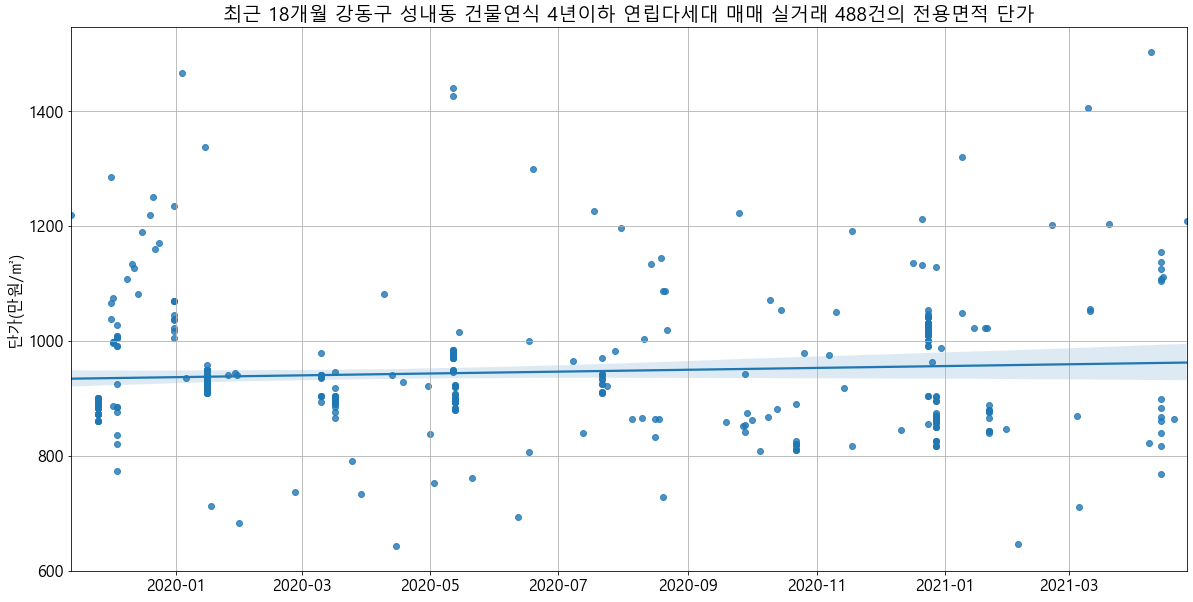

In [24]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 18개월 {} {} 건물연식 4년이하 연립다세대 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대/연립다세대_산포도.png'.format(target_gu, target_dong))

In [25]:
concat_df = pd.concat([target_df])

In [26]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']

In [27]:
selected_df = concat_df[['지번주소', '건물(단지)명', '건축년도', '단가평균', '용도지역명1']].drop_duplicates()
selected_df = selected_df.sort_values(['지번주소']).reset_index(drop=True)
print(selected_df.shape)
selected_df.head()

(45, 5)


,지번주소,건물(단지)명,건축년도,단가평균,용도지역명1
0,서울특별시 강동구 성내동 12-17,천호역 아름채,2017.0,1060.875631,제3종일반주거지역
1,서울특별시 강동구 성내동 127-13,WISH희망,2020.0,928.864970,제2종일반주거지역
2,서울특별시 강동구 성내동 127-6,노블하우스,2017.0,1219.037709,제2종일반주거지역
3,서울특별시 강동구 성내동 130-30,선우빌,2020.0,825.042420,제2종일반주거지역
4,서울특별시 강동구 성내동 144-4,드림빌(144-4),2018.0,1042.772984,제2종일반주거지역


In [28]:
selected_df

,지번주소,건물(단지)명,건축년도,단가평균,용도지역명1
0,서울특별시 강동구 성내동 12-17,천호역 아름채,2017.0,1060.875631,제3종일반주거지역
1,서울특별시 강동구 성내동 127-13,WISH희망,2020.0,928.864970,제2종일반주거지역
2,서울특별시 강동구 성내동 127-6,노블하우스,2017.0,1219.037709,제2종일반주거지역
3,서울특별시 강동구 성내동 130-30,선우빌,2020.0,825.042420,제2종일반주거지역
4,서울특별시 강동구 성내동 144-4,드림빌(144-4),2018.0,1042.772984,제2종일반주거지역
5,서울특별시 강동구 성내동 206-1,성내애스테이1차,2018.0,716.709484,제2종일반주거지역
6,서울특별시 강동구 성내동 219-12,해인하우스14차,2019.0,1120.745159,제2종일반주거지역
7,서울특별시 강동구 성내동 219-9,해인하우스11차,2019.0,868.113523,제2종일반주거지역
8,서울특별시 강동구 성내동 224-7,에바다하우스,2019.0,930.984074,제2종일반주거지역
9,서울특별시 강동구 성내동 226-12,유성그린빌,2017.0,928.990112,제2종일반주거지역


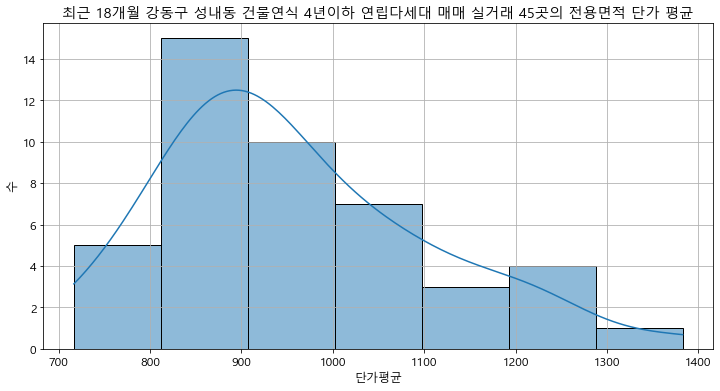

<Figure size 432x288 with 0 Axes>

In [29]:
font = {'size': 12}
matplotlib.rc('font', **font)
plt.figure(figsize=(12,6))
plt.grid(True)
plt.ylabel('수')
plt.title('최근 18개월 {} {} 건물연식 4년이하 연립다세대 매매 실거래 {}곳의 전용면적 단가 평균'.format(target_gu, target_dong, selected_df.shape[0]))
sns.histplot(selected_df['단가평균'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대/분포도.png'.format(target_gu, target_dong))
plt.show()
plt.clf()

In [30]:
selected_df = selected_df.sort_values(['지번주소']).reset_index(drop=True)

In [31]:
selected_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대/실거래가.xlsx'.format(target_gu, target_dong), index=False)